In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

we'll begin by generating a dataset with a bernoulli and a categorical variable which stand in a deterministic relationship to one another

In [3]:
bernoulli = np.repeat([0, 1], 100)
categorical = np.repeat([0, 1], 100)

In [4]:
df = pd.DataFrame({"bernoulli": bernoulli, "categorical": categorical})

we'll then assume we're in the process of learning a crosscat model from these data, and that our current structure hypothesis posits a DPMM with clusters: one containing the first half and the other the second half of the data.

In [5]:
from inferenceql_auto_modeling.cgpm import CGPMModel

In [6]:
schema = {"bernoulli": "bernoulli", "categorical": "categorical", }

In [7]:
mapping_table = {"categorical": {"false": 0, "true": 1}}

In [8]:
additional_metadata = {
    "Zrv": {0: np.repeat([0, 1], 100)},
}

In [9]:
wrapper = CGPMModel.from_data(
    df, schema, mapping_table, model="DPMM", additional_metadata=additional_metadata
)

In [10]:
wrapper

now, we'll look at what the posterior looks like over the entire grid

In [11]:
bernoulli_dim = wrapper.cgpm.dim_for(0)
categorical_dim = wrapper.cgpm.dim_for(1)

grid = bernoulli_dim.hyper_grids

In [12]:
from inferenceql_auto_modeling.slice_sampling import get_logp, set_hyper, slice_sampling

In [83]:
def get_posterior(dim, hyper, grid):
    posterior = np.array([get_logp(bernoulli_dim, hyper, val) for val in grid])

    return posterior

look, the posterior concentrates at the boundaries

In [84]:
def reset_hypers(bernoulli_dim, categorical_dim):
    set_hyper(bernoulli_dim, "alpha", 1)
    set_hyper(bernoulli_dim, "beta", 1)
    set_hyper(categorical_dim, "alpha", 1)

In [115]:
n_grid = 100
grid = np.geomspace(1e-10, 10, n_grid)

def get_beta_posterior(bernoulli_dim):
    alphas = np.zeros(n_grid * n_grid)
    betas = np.zeros(n_grid * n_grid)
    posterior = np.zeros(n_grid * n_grid)
    for i, beta_val in tqdm(enumerate(grid)):
        set_hyper(bernoulli_dim, "beta", beta_val)
        posterior[i*n_grid: (i+1) * n_grid] = get_posterior(bernoulli_dim, "alpha", grid)
        alphas[i*n_grid: (i+1) * n_grid] = grid
        betas[i*n_grid: (i+1) * n_grid] = beta_val

    posterior = np.exp(posterior)
    posterior /= sum(posterior)
    
    return pd.DataFrame({
        "log_alpha": np.log(alphas),
        "log_beta": np.log(betas),
        "posterior": posterior
    })

In [116]:
df = get_beta_posterior(bernoulli_dim)

100it [00:00, 1703.44it/s]


([<matplotlib.axis.XTick at 0x7f016b24fa00>,
 [Text(-23.025850929940457, 0, '1.00e-10'),
  Text(-16.69374192420683, 0, '5.62e-08'),
  Text(-10.361632918473205, 0, '3.16e-05'),
  Text(-4.02952391273958, 0, '1.78e-02'),
  Text(2.3025850929940455, 0, '1.00e+01')])

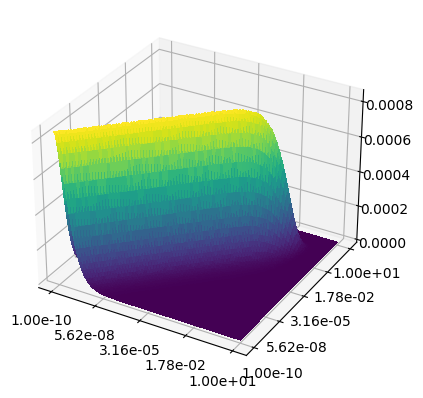

In [119]:
from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(df['log_alpha'], df['log_beta'], df['posterior'], cmap=cm.viridis,
                       linewidth=0, antialiased=False)

def make_axis_labels(axis):
    return ['{:.2e}'.format(float(label)) for label in axis]
    
small_grid_labels = np.geomspace(1e-10, 10, 5)
small_grid_vals = np.log(small_grid_labels)

plt.xticks(
    small_grid_vals,
    make_axis_labels(small_grid_labels)
)
plt.yticks(
    small_grid_vals,
    make_axis_labels(small_grid_labels)
)
# plt.xscale("log")
# plt.yscale("log")

In [27]:
reset_hypers(bernoulli_dim, categorical_dim)

In [28]:
alpha_posterior = get_posterior(bernoulli_dim, "alpha", grid)

In [29]:
reset_hypers(bernoulli_dim, categorical_dim)

In [30]:
beta_posterior = get_posterior(bernoulli_dim, "beta", grid)

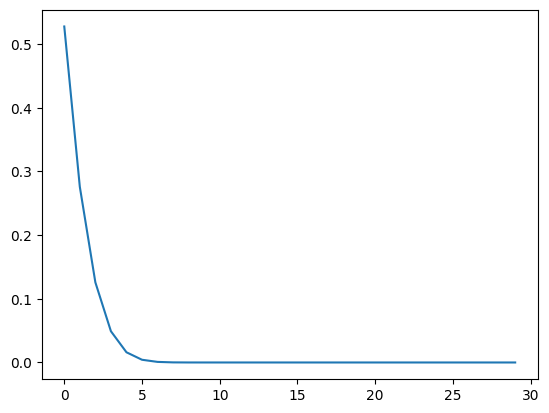

In [31]:
plt.plot(alpha_posterior)

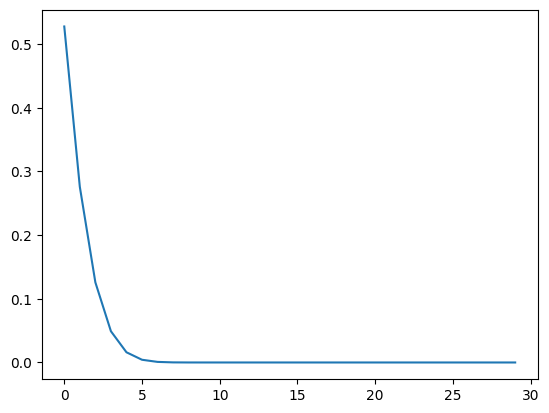

In [32]:
plt.plot(beta_posterior)

this presents an issue if we use CGPM's column hyperparameter transition kernel:

In [33]:
reset_hypers(bernoulli_dim, categorical_dim)

In [34]:
wrapper.cgpm.transition_dim_hypers()

In [35]:
bernoulli_dim.hypers

{'alpha': 1.0, 'beta': 1.0}

In [36]:
categorical_dim.hypers

{'alpha': 1.0}

as we can see, we get stuck near the boundary of the grid

In [42]:
reset_hypers(bernoulli_dim, categorical_dim)

In [43]:
wrapper.inference(N=100, kernels=["column_hypers"])

[                              ] 0.00%> /home/joao-large-population-models/test_auto_modeling/inferenceql_auto_modeling/slice_sampling.py(73)slice_sampling()
     71     import ipdb; ipdb.set_trace()
     72 
---> 73     return np.random.uniform(x_low, x_high)



ipdb>  x_low


0.0026606115827518214


ipdb>  x_low


0.0026606115827518214


ipdb>  x_high


1.40566861101617


ipdb>  q


In [41]:
bernoulli_dim.hypers

{'alpha': 0.12551987149263216, 'beta': 0.3591954000164305}